In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [5]:
# root_path = '../input/cs.csv' # local file
root_path = '/content/archive (3).zip'

In [6]:
stock_df = pd.read_csv(root_path)
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1995-04-17,22.10479,22.10479,22.10479,22.10479,7.994298,0.0
1,1995-04-18,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-04-19,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-04-20,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-04-21,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7011,2022-09-26,4.067,4.198,4.040,4.050,4.050,19101375.0
7012,2022-09-27,4.062,4.107,3.945,3.964,3.964,14651388.0
7013,2022-09-28,3.900,4.001,3.666,4.001,4.001,23437652.0
7014,2022-09-29,3.979,3.990,3.758,3.828,3.828,15592244.0
7015,2022-09-30,3.849,3.976,3.831,3.976,3.976,13156833.0


In [8]:
stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,adj_close,volume
0,1995-04-17,22.10479,22.10479,22.10479,22.10479,7.994298,0.0
1,1995-04-18,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-04-19,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-04-20,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-04-21,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print("Total number of days: ",stock_df.shape[0])
print("Total number of fields: ",stock_df.shape[1])

Total number of days:  7016
Total number of fields:  7


In [10]:
#Checking Null and NA value

In [11]:
print("Null values:", stock_df.isnull().values.sum())
print("NA values:", stock_df.isna().values.any())

Null values: 1782
NA values: True


In [12]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7016 entries, 0 to 7015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       7016 non-null   object 
 1   open       6719 non-null   float64
 2   high       6719 non-null   float64
 3   low        6719 non-null   float64
 4   close      6719 non-null   float64
 5   adj_close  6719 non-null   float64
 6   volume     6719 non-null   float64
dtypes: float64(6), object(1)
memory usage: 383.8+ KB


In [13]:
#Convert Date field into datetime format


In [14]:
# # convert date field from string to Date format
# stock_df['date'] = pd.to_datetime(stock_df.date)
# stock_df.head()

stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7016 entries, 0 to 7015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       7016 non-null   datetime64[ns, UTC]
 1   open       6719 non-null   float64            
 2   high       6719 non-null   float64            
 3   low        6719 non-null   float64            
 4   close      6719 non-null   float64            
 5   adj_close  6719 non-null   float64            
 6   volume     6719 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 383.8 KB


In [15]:

#Find the duration of dataset
print("Starting date: ",stock_df.iloc[0][0])
print("Ending date: ", stock_df.iloc[-1][0])
print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  1995-04-17 00:00:00+00:00
Ending date:  2022-09-30 00:00:00+00:00
Duration:  10028 days 00:00:00


In [16]:
 stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [17]:
#Trend comparision between stock open price, close price, high price, low price

In [18]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'], stock_df['close'],
                                          stock_df['high'], stock_df['low']],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()


In [19]:
#Prepare Stock Close price
#Make separate dataframe of close price

In [20]:
stock_df_close = stock_df[['date','close']]

print("Shape of close dataframe:", stock_df_close.shape)

Shape of close dataframe: (7016, 2)


In [21]:
#Taking only only last 1 year data for prediction

In [22]:
stock_df_close_last_1_year = stock_df_close[stock_df_close['date'] > '2021-10-03']

stock_df_close_last_1_year_original_gt = stock_df_close_last_1_year.copy()

print("Total data for prediction: ",stock_df_close_last_1_year.shape[0])

Total data for prediction:  253


In [23]:
fig = px.line(stock_df_close_last_1_year, x=stock_df_close_last_1_year.date, y=stock_df_close_last_1_year.close,labels={'date':'Date','close':'Close Stock'})

fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [24]:
#Train Test Split before Normalization

In [25]:
training_size=int(len(stock_df_close_last_1_year)*0.80)

test_size=len(stock_df_close_last_1_year)-training_size

train_data,test_data = stock_df_close_last_1_year[0:training_size],stock_df_close_last_1_year[training_size:len(stock_df_close_last_1_year)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

train_data:  (202, 2)
test_data:  (51, 2)


In [26]:
#Normalizing close price

In [27]:
# Need to delte the 'date' column else will get below error
# float() argument must be a string or a number, not 'Timestamp'
del train_data['date']
del test_data['date']

In [28]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(stock_df_close_last_1_year.shape)

(253, 2)


In [29]:
# convert an array of values into a dataset matrix
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
time_step = 15
X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (186, 15)
y_train:  (186,)
X_test:  (35, 15)
y_test (35,)


In [31]:
#For LSTM I need to reshape input to be a 3D Tensor of [samples, time steps, features]

In [33]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# Or in terms of TensorFlow / Keras => [batch_size, time steps, input_dim].
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (186, 15, 1)
X_test:  (35, 15, 1)


In [34]:
#Model Building (GRU)

In [35]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
6/6 [==============================] - 8s 344ms/step - loss: 0.2270 - val_loss: 0.0421
Epoch 2/200
6/6 [==============================] - 0s 53ms/step - loss: 0.0377 - val_loss: 0.1311
Epoch 3/200
6/6 [==============================] - 0s 50ms/step - loss: 0.0493 - val_loss: 0.0832
Epoch 4/200
6/6 [==============================] - 0s 50ms/step - loss: 0.0250 - val_loss: 0.0470
Epoch 5/200
6/6 [==============================] - 0s 51ms/step - loss: 0.0226 - val_loss: 0.0401
Epoch 6/200
6/6 [==============================] - 0s 51ms/step - loss: 0.0170 - val_loss: 0.0423
Epoch 7/200
6/6 [==============================] - 0s 53ms/step - loss: 0.0147 - val_loss: 0.0275
Epoch 8/200
6/6 [==============================] - 0s 51ms/step - loss: 0.0115 - val_loss: 0.0154
Epoch 9/200
6/6 [==============================] - 0s 38ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 10/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 11/200
6/6 [

In [39]:
#Plotting loss chart

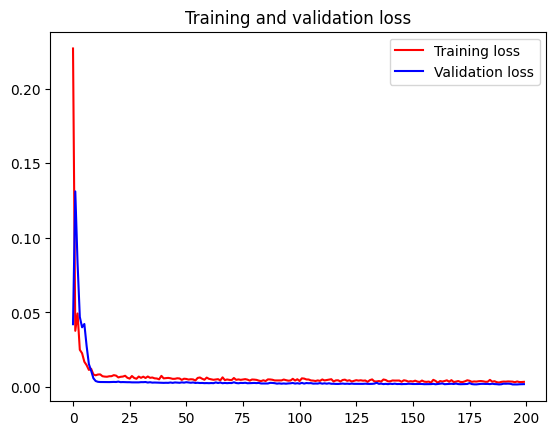

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [41]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 10ms/step


((186, 1), (35, 1))

In [42]:
#Model Evaluation - Transform back the data (i.e. Inverse Scaling)

In [43]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [44]:
#Evaluation metrices RMSE, MSE and MAE

In [45]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.1876203737725013
Train data MSE:  0.03520140465453309
Train data MAE:  0.14378133490777784
-------------------------------------------------------------------------------------
Test data RMSE:  0.21957248154373407
Test data MSE:  0.048212074651273445
Test data MAE:  0.14942158671787809


In [46]:
#Explained variance regression score

In [47]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9810126723126046
Test data explained variance regression score: 0.7728367737280135


In [48]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9808189230756673
Test data R2 score: 0.7332017932163938


In [49]:
#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [50]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))

print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")

print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))

print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0006525189657290157
Test data MGD:  0.002295739805935185
----------------------------------------------------------------------
Train data MPD:  0.004722893780369247
Test data MPD:  0.010487549679178088


In [51]:
#Comparison of original stock close price and predicted close price

In [52]:
# shift train predictions for plotting the look-ahead time for predicted stock values
# And I need this shifting because for the first window of look_back there is NO prediction
# Basically I start at the end-point of the first sliding window
# Note 'train_predict' was defined as train_predict=model.predict(X_train)

look_back=time_step

train_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

train_predict_look_ahead[:, :] = np.nan

# For looking ahead by look_back, I need to start at look_back
train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

####################### TEST #############################
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_close_last_1_year)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': stock_df_close_last_1_year_original_gt['date'],
                       'original_close': stock_df_close_last_1_year_original_gt['close'],
                      'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (253, 2)
Test predicted data:  (253, 2)


ValueError: array length 506 does not match index length 253

In [53]:
print(stock_df_close_last_1_year_original_gt.shape)
print(train_predict_look_ahead.shape)

(253, 2)
(253, 2)


#Predicting next 30 days based on previous 15 days of actual historical values

In [55]:
len(test_data) # 51
len(test_data)-time_step # 36

36

In [56]:
e = test_data[len(test_data)-time_step:]
e

array([[ 0.0455003 ],
       [ 0.00805315],
       [ 0.00161063],
       [ 0.00322126],
       [-0.01852225],
       [-0.02053553],
       [-0.04207771],
       [-0.0384538 ],
       [-0.09281256],
       [-0.20877793],
       [-0.21300584],
       [-0.23032011],
       [-0.22287095],
       [-0.25770083],
       [-0.22790417]])

In [57]:
e.shape

(15, 1)

Need to convert to this (15, 1) matrix to

*   List item
*   List item

(1, 15) Matrix

In [58]:
e.reshape(1, -1)

array([[ 0.0455003 ,  0.00805315,  0.00161063,  0.00322126, -0.01852225,
        -0.02053553, -0.04207771, -0.0384538 , -0.09281256, -0.20877793,
        -0.21300584, -0.23032011, -0.22287095, -0.25770083, -0.22790417]])

In [59]:
# for x_input, I need to pick the last 15 days
# a[start:]      # items starts at the index specified by 'start' and goes through the rest of the array
# So below I start at "len(test_data)-time_step" and go till the rest of the array
# i.e the x_input.shape will always be (15, 1)

x_input=test_data[len(test_data)-time_step:].reshape(1,-1) # time_step is 15
print("x_input.shape ", x_input.shape)
print("x_input", x_input)

print('###########################################################################')

temp_input=list(x_input)
print(temp_input)

x_input.shape  (1, 15)
x_input [[ 0.0455003   0.00805315  0.00161063  0.00322126 -0.01852225 -0.02053553
  -0.04207771 -0.0384538  -0.09281256 -0.20877793 -0.21300584 -0.23032011
  -0.22287095 -0.25770083 -0.22790417]]
###########################################################################
[array([ 0.0455003 ,  0.00805315,  0.00161063,  0.00322126, -0.01852225,
       -0.02053553, -0.04207771, -0.0384538 , -0.09281256, -0.20877793,
       -0.21300584, -0.23032011, -0.22287095, -0.25770083, -0.22790417])]


In [60]:
temp_input=temp_input[0].tolist()
len(temp_input)

15

In [61]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        y_pred = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(y_pred.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1)) # Reshape x_input to a 3D Tensor [samples, time steps, features] before feeding into the model
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())

        lst_output.extend(y_pred.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [62]:
lst_output

[[-0.2251170128583908],
 [-0.22812794148921967],
 [-0.22885678708553314],
 [-0.22897674143314362],
 [-0.22897662222385406],
 [-0.22895990312099457],
 [-0.2289317399263382],
 [-0.2288946956396103],
 [-0.22884579002857208],
 [-0.22879676520824432],
 [-0.22875873744487762],
 [-0.22871898114681244],
 [-0.22868110239505768],
 [-0.2286425083875656],
 [-0.22860939800739288],
 [-0.22857271134853363],
 [-0.2285359650850296],
 [-0.22849978506565094],
 [-0.22846396267414093],
 [-0.2284284383058548],
 [-0.2283930629491806],
 [-0.22835807502269745],
 [-0.22832320630550385],
 [-0.2282886654138565],
 [-0.22825436294078827],
 [-0.22822020947933197],
 [-0.22818638384342194],
 [-0.22815273702144623],
 [-0.22811932861804962],
 [-0.22808612883090973]]

Plotting last 15 days of dataset and next predicted 30 days

In [63]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [64]:
temp_matrix = np.empty((len(last_days)+pred_days+1, 1))

temp_matrix[:] = np.nan

temp_matrix

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [65]:
temp_matrix.shape

(46, 1)

## Need to convert to this (46, 1) matrix to (1, 46) Matrix

---



In [66]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]

# Now for Predicting next 30 days based on previous 15 days of actual historical values - I need a single list in which the first 15 elements will be the 15 days of actual historical values and the next 30 days will be the predicted values

In [67]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step+1] = stock_df_close_last_1_year_original_gt[len(stock_df_close_last_1_year_original_gt)-time_step:]['close'].tolist()

next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

In [68]:
last_original_days_value[0:time_step+1]

[5.334,
 5.148,
 5.116,
 5.124,
 5.016,
 5.006,
 4.899,
 4.917,
 4.647,
 4.071,
 4.05,
 3.964,
 4.001,
 3.828,
 3.976,
 nan]

In [69]:
next_predicted_days_value[time_step+1:]

[3.989843797132373,
 3.974888514623046,
 3.971268338546157,
 3.970672525301576,
 3.970673117414117,
 3.97075616119802,
 3.970896047785878,
 3.971080046758056,
 3.9713229609280827,
 3.9715664672106508,
 3.971755351111293,
 3.9719528206437826,
 3.972140964403749,
 3.972332660838962,
 3.97249712009728,
 3.9726793427318334,
 3.972861861422658,
 3.973041567578912,
 3.973219497397542,
 3.9733959469348195,
 3.97357165633142,
 3.973745441362262,
 3.9739186342805626,
 3.974090198889375,
 3.9742605792731047,
 3.974430219516158,
 3.9745982314497232,
 3.9747653552144766,
 3.9749312947541475,
 3.9750961980968715]

In [71]:
len(last_original_days_value[0:time_step+1])

16

In [72]:
len(next_predicted_days_value[time_step+1:])

30

In [73]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new_pred_plot.tail()


,last_original_days_value,next_predicted_days_value
41,3.974430,3.974430
42,3.974598,3.974598
43,3.974765,3.974765
44,3.974931,3.974931
45,3.975096,3.975096


In [74]:
new_pred_plot.shape

(46, 2)

In [75]:
names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(visible=True, name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()


# Plotting entire Closing Stock Price with next 30 days period of prediction

In [78]:
lstmdf=stock_df_close_last_1_year.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


AttributeError: 'DataFrame' object has no attribute 'tolist'

In [80]:
lstmdf = stock_df_close_last_1_year.values.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf = scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

ValueError: Plotly Express cannot process wide-form data with columns of different type.